# 선형 회귀 훈련 두 가지 방법

- 직접 계산할 수 있는 공식을 사용해 훈련 세트에 가장 잘 맞는 모델 파라미터를 해석적으로 구함.
- 경사 하강법(GD)이라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최소화시킴. 결국 앞의 방법과 동일한 파라미터로 수렴. 경사 하강법의 변종으로 배치 경사 하강법, 미니배치 경사 하강법, 확률적 경사 하강법(SGD)도 살펴봄.

# 4.1 선형 회귀

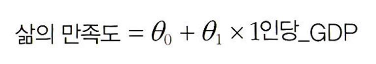

이 모델은 입력 특성인 1인당_GDP에 대한 선형 함수. theta_0, theta_1이 모델 파라미터임.
더 일반적으로 선형 모델은 입력 특성의 가중치 합과 **편향(절편)** 이라는 상수를 더해 예측을 만듦.

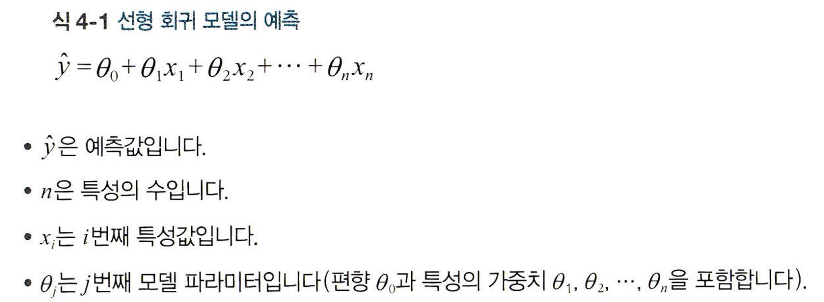

벡터 형태로 더 간단하게 쓸 수 있음.
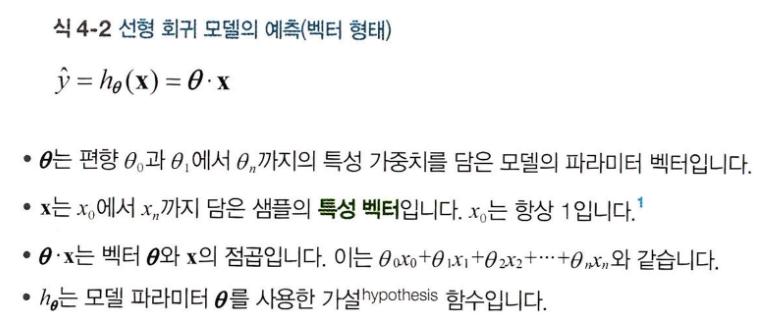

훈련 세트 X에 대한 선형 회귀 가설 h_theta의 MSE는 아래처럼 계산함.

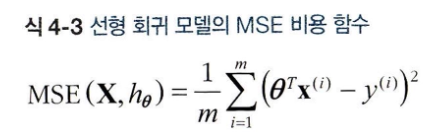

간단 표기를 위해 MSE(X, h_theta) 대신 MSE(theta)라고 쓸 예정.

## 4.1.1 정규방정식

비용 함수를 최소화하는 theta 값을 찾기 위한 **해석적인 방법** 이 있음. 다른 말로 하면 바로 결과를 얻을 수 있는 수학 공식이 있는데, 이를 **정규 방정식(normal equation)** 이라고 함.

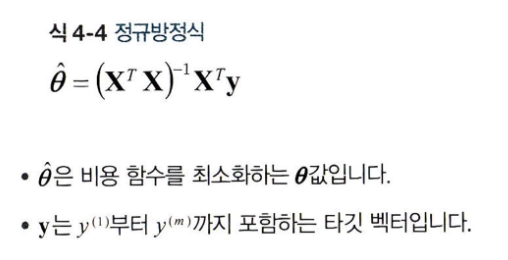

In [2]:
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

In [4]:
# 정규방정식을 사용해 theta_hat을 계산. inv() 함수를 사용해 역행렬 계산, dot() 메서드 사용해 행렬 곱셈을 수행.
X_b = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

theta_best

array([[4.13799085],
       [2.97066918]])

In [6]:
# theta_hat을 사용해 에측
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.13799085],
       [10.07932921]])

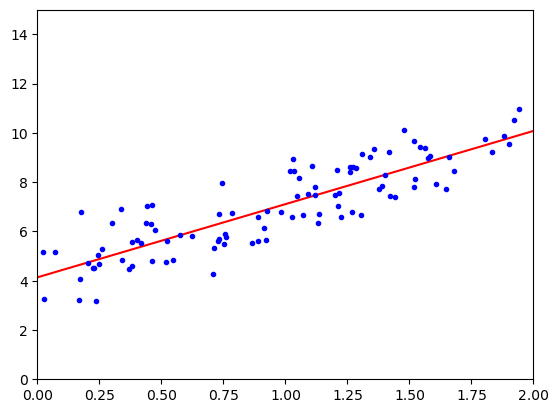

In [8]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [11]:
lin_reg.intercept_, lin_reg.coef_

(array([4.13799085]), array([[2.97066918]]))

In [12]:
lin_reg.predict(X_new)

array([[ 4.13799085],
       [10.07932921]])

In [16]:
# LinearRegression 클래스는 scipy.linalg.lstsq() 함수(최소 제곱(least squares)에서 이름을 따옴)를 기반으로 함. 이 함수를 직접 호출 가능
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.13799085],
       [2.97066918]])

In [18]:
# np.linalg.pinv() 함수 사용해 유사역행렬 직접 구할 수 있음.
np.linalg.pinv(X_b).dot(y)

array([[4.13799085],
       [2.97066918]])

유사역행렬 자체는 **특잇값 분해(SVD)** 라 불리는 표준 행렬 분해 기법을 사용해 계산됨. SVD는 훈련 세트 행렬 X를 3개의 행렬 곱셈 **UΣV^T** 로 분해.

유사역행렬은 **X+ = VΣ+U^T** 로 계산
- Σ+를 계산하기 위해 알고리즘이 Σ를 먼저 구함
- 그다음 어떤 낮은 임곗값보다 작은 모든 수를 0으로 바꿈
- 그 다음 0이 아닌 모든 값을 역수로 치환
- 마지막으로 만들어진 행렬을 전치

* 극단적인 경우도 처리 가능. 실제로 m < n이거나 어떤 특성이 중복되어 행렬 **X^TX** 의 역행렬이 없다면 정규방정식이 작동하지 않음. 하지만 유사역행렬은 항상 구할 수 있음.

## 4.1.2 계산 복잡도

정규방정식은 (n+1)*(n+1) 크기가 되는 **X^TX** 의 역행렬을 계산(n은 특성수). 역행렬을 계산하는 **계산 복잡도(computational complexity)** 는 일반적으로 O(n^2.4)에서 O(n^3) 사이임. 다시 말해 특성 수가 두 배로 늘어나면 계산 시간이 대략 2^2.4 = 5.3에서 2^3 = 8배로 증가.

# 4.2 경사 하강법

**경사 하강법(gradient descent)** 은 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘

- 기본 아이디어: 비용 함수(loss function)를 최소화하기 위해 반복해서 파라미터를 조정
- 파라미터 벡터 theta 에 대해 비용 함수의 현재 그레디언트를 계산
- 그레디언트가 감소하는 방향으로 진행
- 그 값이 0이 되면 최솟값에 도달한 것

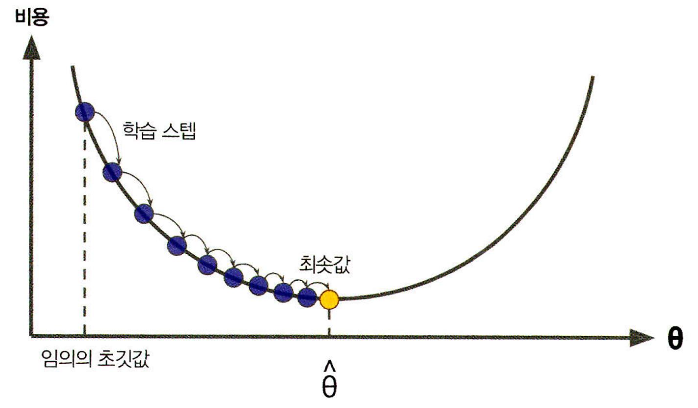

- 중요 파라미터: 스텝의 크기로, learning rate(학습률) 하이퍼파라미터로 결정됨
- 학습률이 너무 작으면 알고리즘 수렴 위해 반복을 많이 진행해야 하므로 시간이 오래 걸림

### 학습률이 너무 작을 때

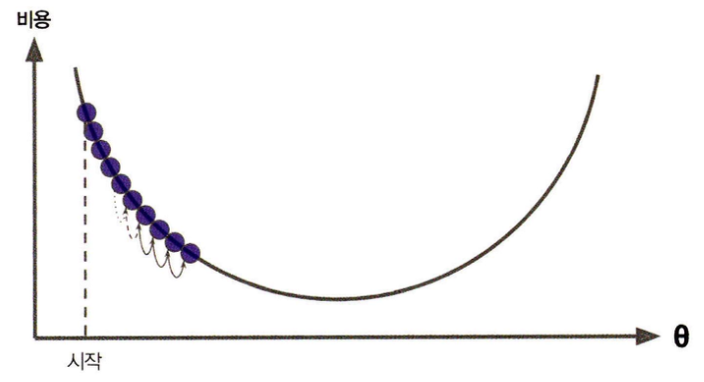

### 학습률이 너무 클 때

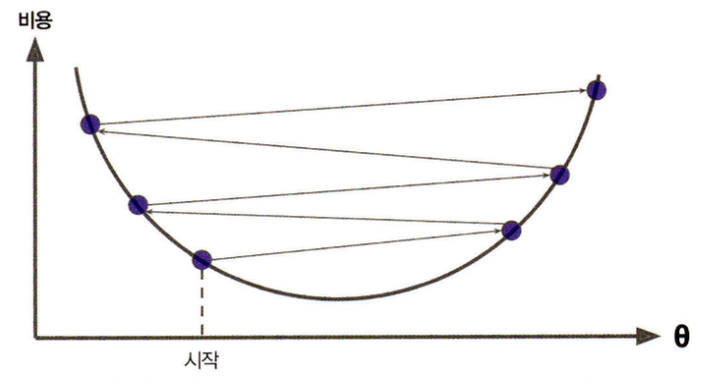ㅡ

## 4.2.1 배치 경사 하강법

- 매 스텝에서 훈련 데이터 전체를 사용
- 매우 큰 훈련 세트에서는 아주 느림

In [26]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta + gradients

theta

array([[-inf],
       [-inf]])

In [28]:
eta = 0.02 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta + gradients

theta

array([[-inf],
       [-inf]])

In [30]:
eta = 0.5 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta + gradients

theta

array([[-inf],
       [-inf]])

### 수렴율

- 비용 함수의 모양에 따라 달라지겠지만 ε 범위 안에서 최적의 솔루션에 도달하기 위해서는 O(1/ε)의 반복이 걸릴 수 있음.
- 허용 오차 ε을 1/10로 줄이면 알고리즘의 반복은 10배 늘어날 것

## 4.2.2 확률적 경사 하강법

- 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레디언트를 계산
- 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한 번에 하나의 샘플을 처리하면 알고리즘이 확실히 빠름.
- 또한, 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련 세트도 훈련 시킬 수 있음.
- 반면, 확률적이기 때문에 이 알고리즘은 배치 경사 하강법보다 훨씬 불안정함.
- 이 딜레마를 해결하는 방법은 '학습률을 점진적으로 감소시키는 것'
- 학습 스케줄(learning schedule): 매 반복에서 학습률을 결정하는 함수

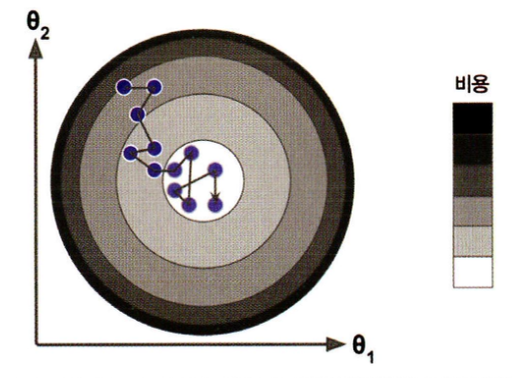

In [34]:
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [36]:
theta

array([[4.15034346],
       [2.96204546]])

In [38]:
# SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스 사용
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [40]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.17920118]), array([3.0325359]))

## 4.2.3 미니배치 경사 하강법

- 미니배치 라 부르는 임의의 작은 샘플 세트에 대해 그레디언트를 계산
- 확률적 경사 하강법에 비해 미니배치 경사 하강법의 주요 장점은 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상임.
- 특히 미니배치를 어느 정도 크게 하면 이 알고리즘은 파라미터 공간에서 SGD보다 덜 불규칙하게 움직임.

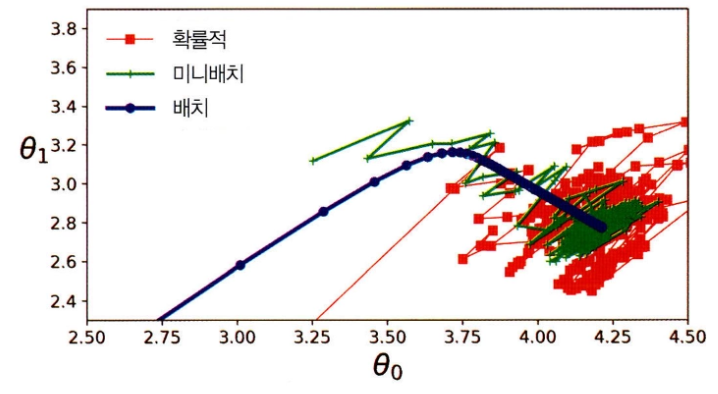

### 선형 회귀를 사용한 알고리즘 비교

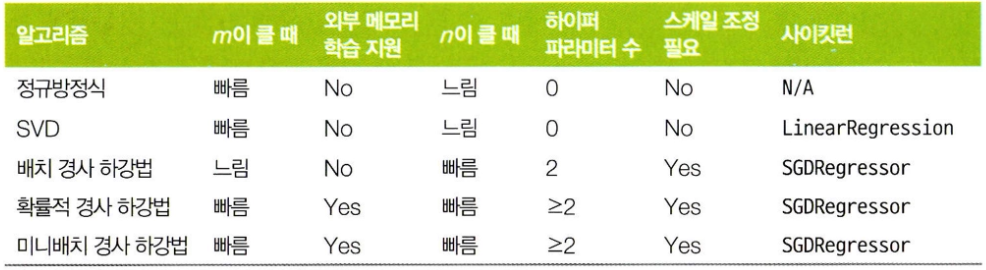

# 4.3 다항 회귀

- 가지고 있는 데이터가 단순한 직선보다 복잡한 형태이며, 비선형 데이터를 학습하는 데 선형 모델을 사용할 수 있음
- 방법은 각 특성의 거듭제곱을 새로운 특성으로 추가, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것

In [45]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [47]:
# 사이킷런의 PolynomialFeatures 사용해 훈련 데이터 변환
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [49]:
X[0]

array([-0.9916855])

In [51]:
X_poly[0]

array([-0.9916855 ,  0.98344014])

In [53]:
# 확장된 훈련 데이터에 linear reg 적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.79987582]), array([[0.97370042, 0.52053226]]))

# 4.4 학습 곡선

- 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타냄.
- 단순히 훈련 세트에서 크기가 달느 서브 세트를 만들어 모델을 여러 번 훈련시킴.

In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")

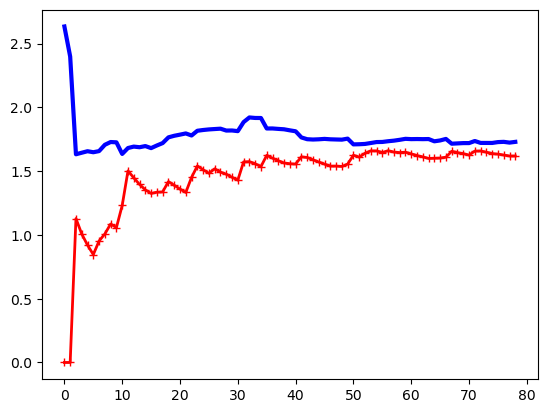

In [70]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

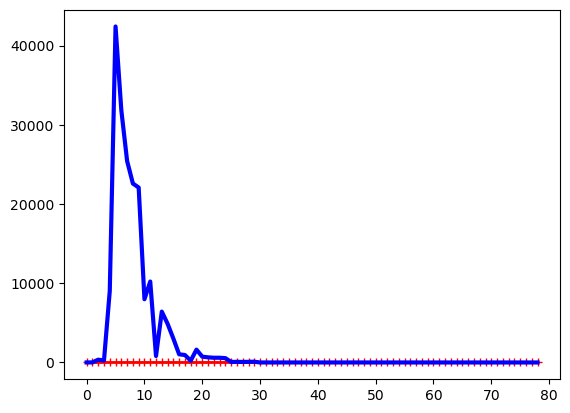

In [74]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

### 두 그래프의 중요 차이점
- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음.
- 두 곡선 사이에 공간이 있음. 이 말은 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이는, 이는 과대적합 모델의 특징임. 그러나 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐.

### 편향/분산 트레이드오프

- 모델의 일반화 오차는 세 가지 다른 종류의 오차의 합으로 표현할 수 있음.
--------
- 편향: 일반화 오차 중에서 편향은 잘못된 가정으로 인한 것. 예를 들어 데이터가 실제로는 2차인데 선형으로 가정하는 경우. 편향이 큰 모델은 훈련 데이터에 과소적합되기 쉬움.
- 분산(variance): 분산은 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 떄문. 자유도가 높은 모델(예를 들면 고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합 되는 경향이 있음.
- 줄일 수 없는 오차(irreducible error): 데이터 자체에 있는 잡음 때문에 발생. 이 오차를 줄일 수 있는 유일한 방법은 데이터에서 잡음을 제거하는 것. (예를 들어 고장 난 센서 같은 데이터 소스를 고치거나 이상치를 감지해 제거)
---------
- 모델의 복잡도가 커지면 통상적으로 분산은 늘어나고 편향은 줄어듦.
- 반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아짐.
- > 그래서 트레이드 오프라고 함.